# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a complete working example to develop an streamaligned mixed-element mesh for Coweeta watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `Coweeta.exo`, includes all labeled sets

In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

In [2]:
## FIX ME -- why is this broken without importing netcdf first?
import netCDF4

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

making directory: /home/ecoon/code/watershed_workflow/data/meteorology/aorc


In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import pandas as pd
import geopandas as gpd
import cftime, datetime
pd.options.display.max_columns = None

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.source_list
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.meteorology
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)


# Input: Parameters and other source data

Note, this section will need to be modified for other runs of this workflow in other regions.

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())

# REMOVE THIS PORTION OF THE CELL for general use outside of Coweeta -- this is just locating 
# the working directory within the WW directory structure
if cwd[-1] == 'Coweeta':
    pass
elif cwd[-1] == 'examples':
    cwd.append('Coweeta')
else:
    cwd.extend(['examples','Coweeta'])
# END REMOVE THIS PORTION

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
def toOutput(filename):
    return os.path.join(output_dir, filename)

work_dir = os.path.join(*cwd)
def toWorkingDir(filename):
    return os.path.join(work_dir, filename)
       

In [6]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)


In [7]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'Coweeta'
coweeta_shapefile = './Coweeta/input_data/coweeta_basin.shp'

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
simplify = 60                   # length scale to target average edge 
ignore_small_rivers = 2         # remove rivers with fewer than this number of reaches -- important for NHDPlus HR 
prune_by_area_fraction = 0.01   # prune any reaches whose contributing area is less than this fraction of the domain

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

#refine_L0 = 75
#refine_L1 = 200

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

min_angle = 32 # degrees


# Simulation control
# - note that we use the NoLeap calendar, same as DayMet.  Simulations are typically run over the "water year"
#   which starts August 1.
start = cftime.DatetimeNoLeap(2010,8,1)
end = cftime.DatetimeNoLeap(2011,8,1)


# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils



In [8]:
# a dictionary of output_filenames -- will include all filenames generated
output_filenames = {}

In [9]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

In [10]:
# get the shape and crs of the shape
coweeta_source = watershed_workflow.source_list.ManagerShapefile(coweeta_shapefile, id_name='BASIN_CODE')
coweeta = coweeta_source.getShapes(out_crs=crs)


2025-08-26 22:33:46,139 - root - INFO: fixing column: geometry


In [11]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus HR']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# DELETE THIS SECTION for non-Coweeta runs
dtb_file = os.path.join(data_dir, 'soil_structure', 'DTB', 'DTB.tif')
geo_file = os.path.join(data_dir, 'soil_structure', 'GLHYMPS', 'GLHYMPS.shp')

# GLHYMPs is a several-GB download, so we have sliced it and included the slice here
sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS(geo_file)

# The Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.
# Here we will use a clipped version of that map.
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster(dtb_file)

# END DELETE THIS SECTION

# log the sources that will be used here
watershed_workflow.source_list.logSources(sources)


2025-08-26 22:33:46,159 - root - INFO: Using sources:
2025-08-26 22:33:46,160 - root - INFO: --------------
2025-08-26 22:33:46,160 - root - INFO: HUC: WBD
2025-08-26 22:33:46,160 - root - INFO: hydrography: NHDPlus HR
2025-08-26 22:33:46,160 - root - INFO: DEM: 3DEP
2025-08-26 22:33:46,160 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-08-26 22:33:46,160 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-08-26 22:33:46,161 - root - INFO: land cover: NLCD 2021 L48
2025-08-26 22:33:46,161 - root - INFO: LAI: MODIS
2025-08-26 22:33:46,161 - root - INFO: depth to bedrock: raster: "DTB.tif"
2025-08-26 22:33:46,161 - root - INFO: meteorology: AORC v1.1


# Basin Geometry

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

## the Watershed

In [12]:
coweeta

,AREA,PERIMETER,CWTBASINNA,CWTBASIN_1,BASIN_CODE,SPOT,LABEL,geometry,ID,name
0,1.626020e+07,17521.768,2,1,1,-9999,Coweeta Hydrologic Lab,"POLYGON ((1443453.518 -645937.256, 1443489.888...",1,1


2025-08-26 22:33:46,194 - root - INFO: Removing holes on 1 polygons
2025-08-26 22:33:46,194 - root - INFO:   -- removed interior
2025-08-26 22:33:46,195 - root - INFO:   -- union
2025-08-26 22:33:46,195 - root - INFO: Parsing 1 components for holes
2025-08-26 22:33:46,195 - root - INFO:   -- complete


<Axes: >

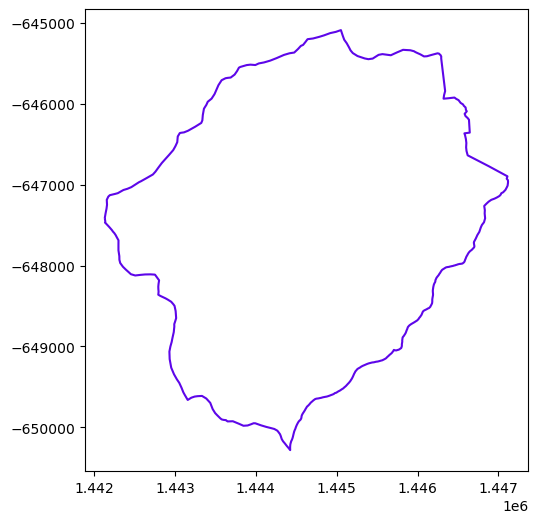

In [13]:
# Construct and plot the WW object used for storing watersheds
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

## the Rivers 

In [14]:
# download/collect the river network within that shape's bounds
reaches = sources['hydrography'].getShapesByGeometry(watershed.exterior, crs, out_crs=crs)
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers
sources['hydrography'].name, sources['hydrography'].source

2025-08-26 22:33:46,367 - root - INFO: fixing column: geometry
2025-08-26 22:33:46,371 - root - INFO: fixing column: catchment


('NHDPlus HR', 'HyRiver.NHDPlusHR')

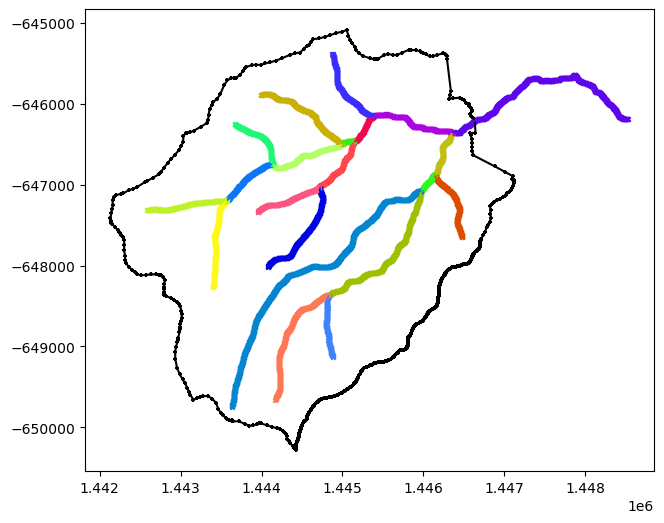

In [15]:
# plot the rivers and watershed
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [16]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    

In [17]:
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying -- this sets the discrete length scale of both the watershed boundary and the rivers
watershed_workflow.simplify(watershed, rivers, refine_L0, refine_L1, refine_d0, refine_d1)

# simplify may remove reaches from the rivers object
# -- this call removes any reaches from the dataframe as well, signaling we are all done removing reaches
#
# ETC: NOTE -- can this be moved into the simplify call?
for river in rivers:
    river.resetDataFrame()

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

2025-08-26 22:33:46,515 - root - INFO: 
2025-08-26 22:33:46,515 - root - INFO: Simplifying
2025-08-26 22:33:46,515 - root - INFO: ------------------------------
2025-08-26 22:33:46,516 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-26 22:33:46,516 - root - INFO: Presimplify to remove colinear, coincident points.
2025-08-26 22:33:46,520 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-26 22:33:46,521 - root - INFO: Pruning leaf reaches < 125
2025-08-26 22:33:46,521 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-26 22:33:46,522 - root - INFO: Merging internal reaches < 125
2025-08-26 22:33:46,522 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-26 22:33:46,5

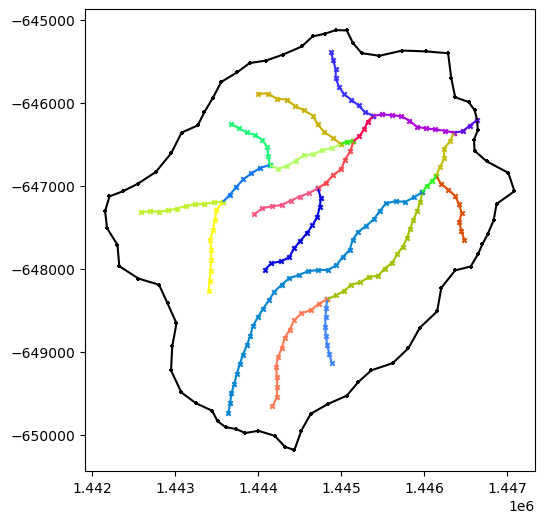

In [18]:
plot(watershed, rivers)

In [19]:
watershed.df.columns

Index(['AREA', 'PERIMETER', 'CWTBASINNA', 'CWTBASIN_1', 'BASIN_CODE', 'SPOT',
       'LABEL', 'geometry', 'ID', 'name', 'outlet'],
      dtype='object')

In [20]:
# this generates a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
m = watershed_workflow.makeMap(m)
m

## Mesh Geometry

Discretely create the stream-aligned mesh.  Download elevation data, and condition the mesh discretely to make for better topography.

2025-08-26 22:33:46,921 - root - INFO: 
2025-08-26 22:33:46,922 - root - INFO: Stream-aligned Meshing
2025-08-26 22:33:46,922 - root - INFO: ------------------------------
2025-08-26 22:33:46,922 - root - INFO: Creating stream-aligned mesh...
2025-08-26 22:33:46,939 - root - INFO: Adjusting HUC to match reaches at outlet
2025-08-26 22:33:46,948 - root - INFO: 
2025-08-26 22:33:46,949 - root - INFO: Triangulation
2025-08-26 22:33:46,949 - root - INFO: ------------------------------
2025-08-26 22:33:46,953 - root - INFO: Triangulating...
2025-08-26 22:33:46,954 - root - INFO:    443 points and 444 facets
2025-08-26 22:33:46,954 - root - INFO:  checking graph consistency
2025-08-26 22:33:46,954 - root - INFO:  tolerance is set to 1.0
2025-08-26 22:33:46,956 - root - INFO:  building graph data structures
2025-08-26 22:33:46,957 - root - INFO:  triangle.build...
2025-08-26 22:33:47,089 - root - INFO:   ...built: 1427 mesh points and 2409 triangles
2025-08-26 22:33:47,089 - root - INFO: Plot

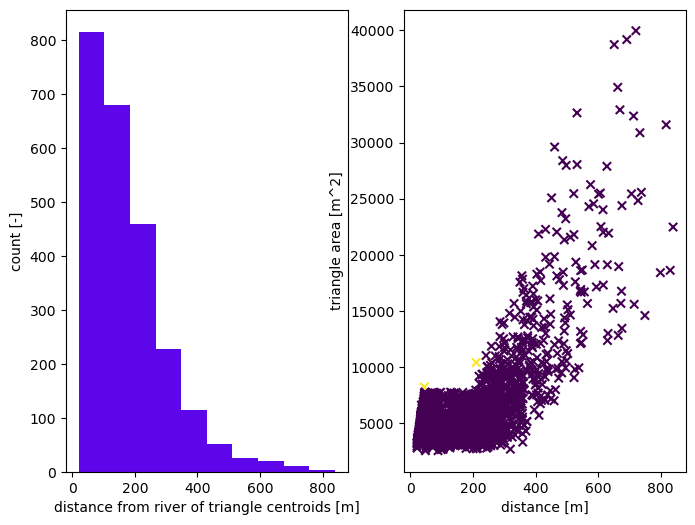

In [21]:
# Refine triangles if they get too acute

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

# create the mesh
m2, areas, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, 
                                                            river_width=widths,
                                                            refine_min_angle=min_angle,
                                                            refine_distance=[refine_d0, refine_A0, refine_d1, refine_A1],
                                                            diagnostics=True)

In [22]:
# get a raster for the elevation map, based on 3DEP
dem = sources['DEM'].getDataset(watershed.exterior, watershed.crs)['dem']

# provide surface mesh elevations
watershed_workflow.elevate(m2, dem)

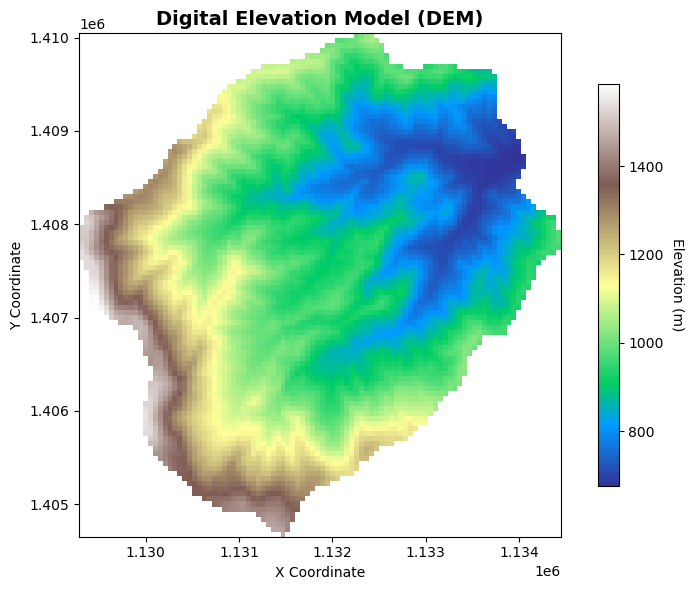

In [23]:
# Plot the DEM raster
fig, ax = plt.subplots()

# Plot the DEM data
im = dem.plot(ax=ax, cmap='terrain', add_colorbar=False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)

# Add title and labels
ax.set_title('Digital Elevation Model (DEM)', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [24]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [25]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

2025-08-26 22:33:48,473 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


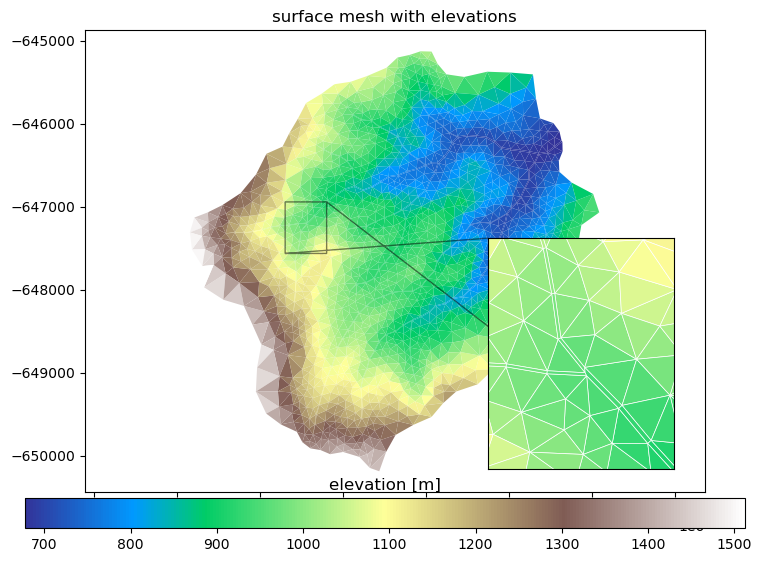

In [26]:
# plotting surface mesh with elevations
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = m2.plot(facecolors='elevation', edgecolors=None, ax=ax, linewidth=0.5, colorbar=False)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', edgecolors='white', ax=ax2, colorbar=False)
ax2.set_aspect('equal', 'datalim')

xlim = (1.4433e6, 1.4438e6)
ylim = (-647000, -647500)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [27]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=250, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.addStreamOrderRegions(m2, rivers)

2025-08-26 22:33:48,574 - root - INFO: Adding regions for 1 polygons


In [28]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 2593 : "1"
10001 : CELL : 2593 : "1 surface"
10002 : FACE : 76 : "1 boundary"
10003 : FACE : 5 : "1 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 184 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 46 : "stream order 2"
10008 : CELL : 122 : "stream order 1"


# Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [29]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)['cover']

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-08-26 22:33:48,669 - root - INFO: Found land cover dtypes: uint8
2025-08-26 22:33:48,670 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(127)}


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(127)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (1.0, 1.0, 1.0)]


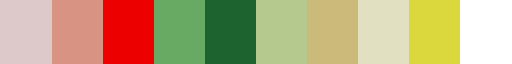

In [30]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

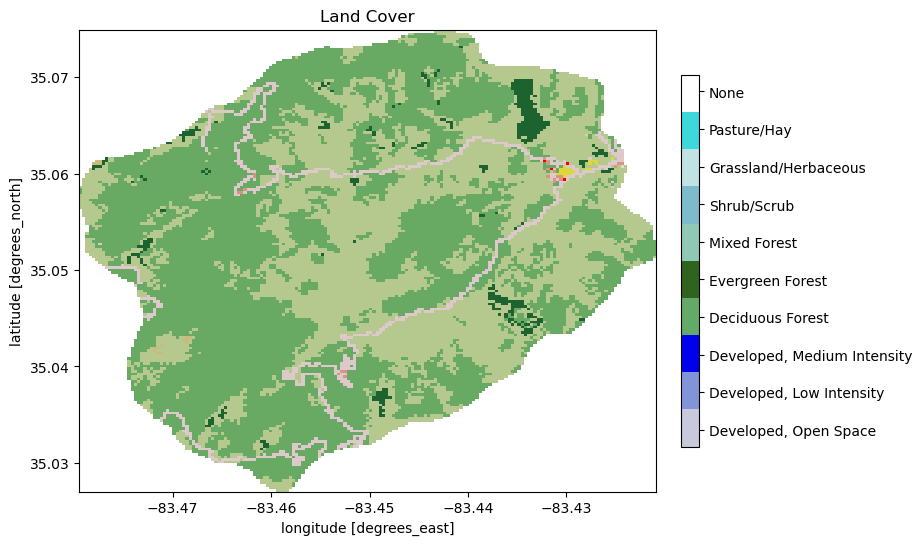

In [31]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
ax.set_title('Land Cover')
plt.show()

In [32]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})



In [33]:
# double-check that nan not in the values
assert 127 not in m2_nlcd

# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.85882352941, 0.84705882353, 0.23921568628)]


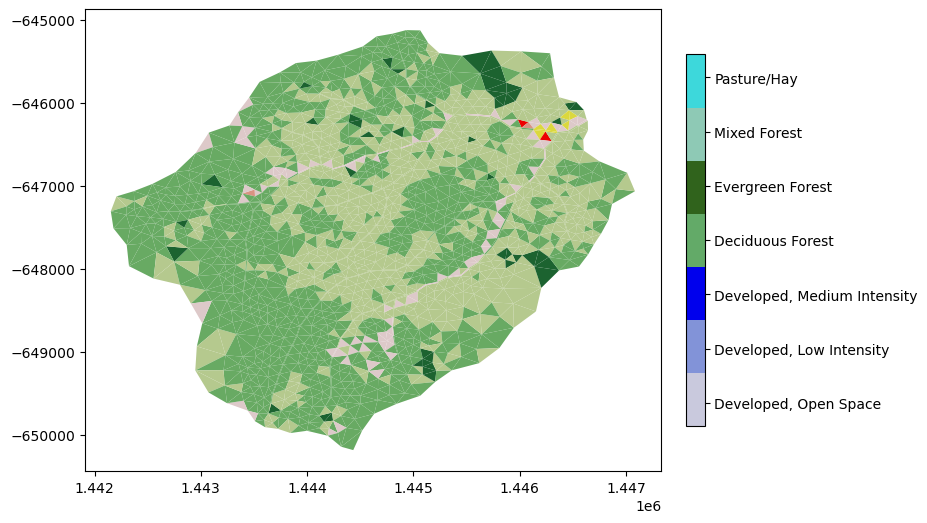

In [34]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [35]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [36]:
nlcd_labels_dict

{np.uint8(21): 'Developed, Open Space',
 np.uint8(22): 'Developed, Low Intensity',
 np.uint8(23): 'Developed, Medium Intensity',
 np.uint8(41): 'Deciduous Forest',
 np.uint8(42): 'Evergreen Forest',
 np.uint8(43): 'Mixed Forest',
 np.uint8(81): 'Pasture/Hay'}

In [37]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 2593 : "1"
10001 : CELL : 2593 : "1 surface"
10002 : FACE : 76 : "1 boundary"
10003 : FACE : 5 : "1 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 184 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 46 : "stream order 2"
10008 : CELL : 122 : "stream order 1"
21 : CELL : 106 : "Developed, Open Space"
22 : CELL : 2 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 1340 : "Deciduous Forest"
42 : CELL : 47 : "Evergreen Forest"
43 : CELL : 1088 : "Mixed Forest"
81 : CELL : 8 : "Pasture/Hay"


## MODIS LAI

Leaf area index is needed on each land cover type -- this is used in the Evapotranspiration calculation.

In [38]:
# download LAI and corresponding LULC datasets -- these are actually already downloaded, 
# as the MODIS AppEEARS API is quite slow
#
# Note that MODIS does NOT work with the noleap calendar, so we have to convert to actual dates first
start_leap = cftime.DatetimeGregorian(start.year, start.month, start.day)
end_leap = cftime.DatetimeGregorian(end.year, end.month, end.day)
modis_data = sources['LAI'].getDataset(watershed.exterior, crs, start_leap, end_leap)


2025-08-26 22:33:48,966 - root - INFO: Building request for bounds: ['-83.4826', '35.0237', '-83.4178', '35.0782']
2025-08-26 22:33:48,966 - root - INFO: Requires files:
2025-08-26 22:33:48,967 - root - INFO:  ... /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2011_35.0782x-83.4826_35.0237x-83.4178.nc
2025-08-26 22:33:48,967 - root - INFO:  ... /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2011_35.0782x-83.4826_35.0237x-83.4178.nc
2025-08-26 22:33:48,967 - root - INFO: files exist locally.


In [39]:
assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float64


In [40]:
# MODIS data comes with time-dependent LAI AND time-dependent LULC -- just take the mode to find the most common LULC
modis_data['LULC'] = watershed_workflow.data.computeMode(modis_data['LULC'], 'time_LULC')

# now it is safe to have only one time
modis_data = modis_data.rename({'time_LAI':'time'})

# remove leap day (366th day of any leap year) to match our Noleap Calendar
modis_data = watershed_workflow.data.filterLeapDay(modis_data)

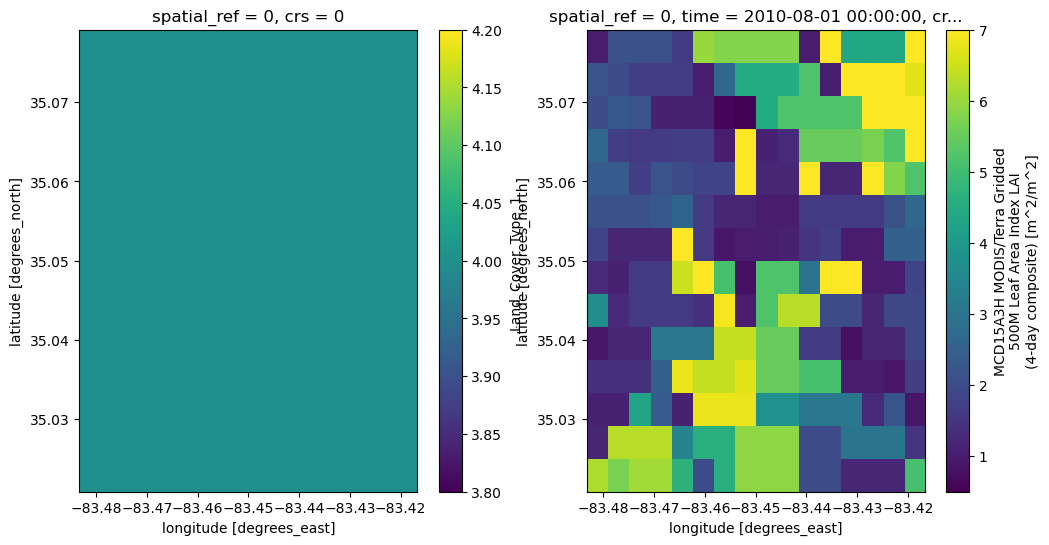

In [41]:
# plot the MODIS data -- note the entire domain is covered with one type for Coweeta (it is small!)
fig, axs = plt.subplots(1,2, figsize=(12,6))
modis_data['LULC'].plot.imshow(ax=axs[0])
modis_data['LAI'][0].plot.imshow(ax=axs[1])

In [42]:
# compute the transient time series
modis_lai = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [43]:
modis_lai

,time,Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.243011
1,2010-08-05 00:00:00,4.847312
2,2010-08-09 00:00:00,3.476344
3,2010-08-13 00:00:00,4.193548
4,2010-08-17 00:00:00,3.186022
...,...,...
88,2011-07-16 00:00:00,6.363441
89,2011-07-20 00:00:00,4.729032
90,2011-07-24 00:00:00,4.132258
91,2011-07-28 00:00:00,5.263441


2025-08-26 22:33:49,282 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_MODIS_transient.h5


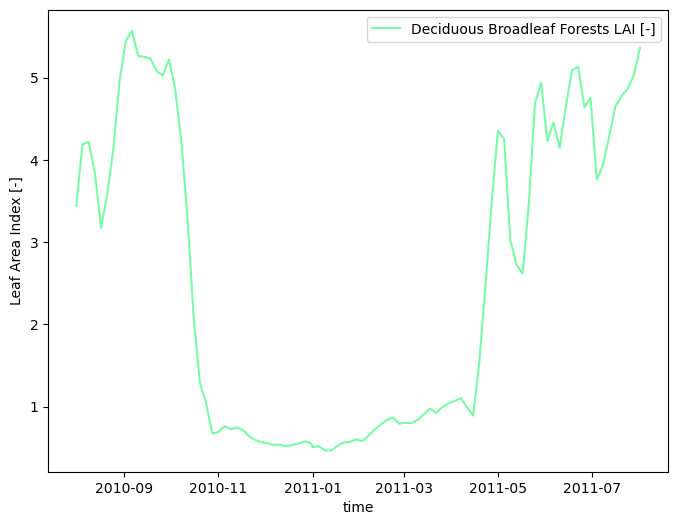

In [44]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai, 'time')

# save the MODIS time series to disk
output_filenames['modis_lai_transient'] = toOutput(f'{name}_LAI_MODIS_transient.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_transient'], modis_lai_smoothed)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS')

2025-08-26 22:33:49,370 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5


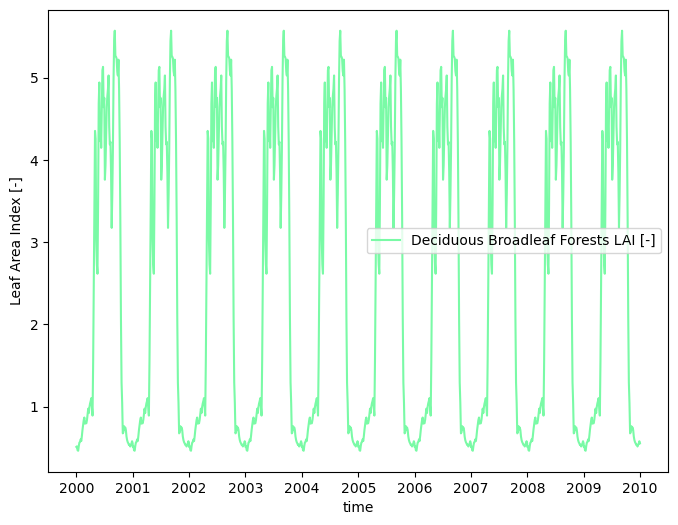

In [45]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed, 'time', output_nyears=10, 
                                                                  start_year=2000)

output_filenames['modis_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_MODIS_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_cyclic_steadystate'], modis_lai_typical)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS')

## Crosswalk of LAI to NLCD LC

2025-08-26 22:33:49,469 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-08-26 22:33:49,469 - root - INFO:   unique MODIS: [np.float64(4.0)]
2025-08-26 22:33:49,469 - root - INFO:   unique NLCD: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81)]


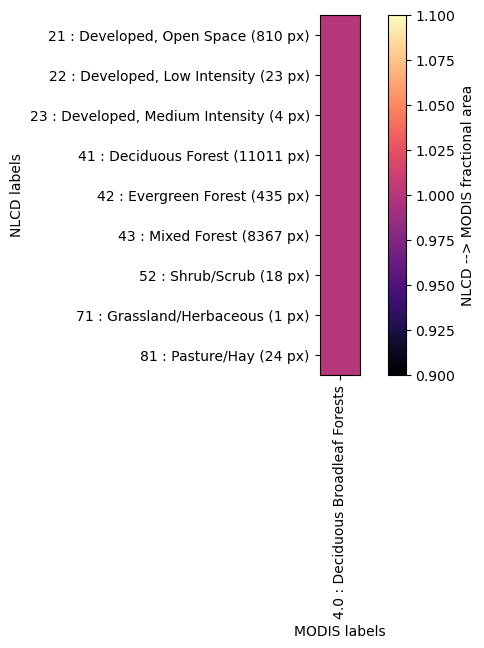

In [46]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_data['LULC'], nlcd, method='fractional area')

In [47]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
nlcd_lai_transient = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_smoothed)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_transient)
nlcd_lai_transient

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time,"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-]
0,2010-08-01 00:00:00,3.441091,3.441091,0.0,3.441091,3.441091,3.441091,3.441091,3.441091,3.441091
1,2010-08-05 00:00:00,4.188735,4.188735,0.0,4.188735,4.188735,4.188735,4.188735,4.188735,4.188735
2,2010-08-09 00:00:00,4.219150,4.219150,0.0,4.219150,4.219150,4.219150,4.219150,4.219150,4.219150
3,2010-08-13 00:00:00,3.846493,3.846493,0.0,3.846493,3.846493,3.846493,3.846493,3.846493,3.846493
4,2010-08-17 00:00:00,3.173528,3.173528,0.0,3.173528,3.173528,3.173528,3.173528,3.173528,3.173528
...,...,...,...,...,...,...,...,...,...,...
88,2011-07-16 00:00:00,4.643113,4.643113,0.0,4.643113,4.643113,4.643113,4.643113,4.643113,4.643113
89,2011-07-20 00:00:00,4.774706,4.774706,0.0,4.774706,4.774706,4.774706,4.774706,4.774706,4.774706
90,2011-07-24 00:00:00,4.864055,4.864055,0.0,4.864055,4.864055,4.864055,4.864055,4.864055,4.864055
91,2011-07-28 00:00:00,5.026882,5.026882,0.0,5.026882,5.026882,5.026882,5.026882,5.026882,5.026882


In [48]:
# write the NLCD-based time series to disk
output_filenames['nlcd_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_NLCD_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_cyclic_steadystate'], nlcd_lai_cyclic_steadystate)

output_filenames['nlcd_lai_transient'] = toOutput(f'{name}_LAI_NLCD_{start.year}_{end.year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_transient'], nlcd_lai_transient)

2025-08-26 22:33:49,566 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5
2025-08-26 22:33:49,569 - root - INFO: Writing HDF5 file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta_LAI_NLCD_2010_2011.h5


# Subsurface Soil, Geologic Structure

## NRCS Soils

In [49]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs, out_crs=crs)


2025-08-26 22:33:49,603 - root - INFO: Attempting to download source for target '/home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/input_data/soil_structure/SSURGO/SSURGO_-83.4782_35.0281_-83.4222_35.0738.shp'
2025-08-26 22:33:49,608 - root - INFO:   Found 451 shapes.
2025-08-26 22:33:49,667 - root - INFO: found 41 unique MUKEYs.
2025-08-26 22:33:49,999 - root - INFO: Running Rosetta for van Genutchen parameters
2025-08-26 22:33:50,038 - root - INFO:   ... done
2025-08-26 22:33:50,040 - root - INFO:   requested 41 values
2025-08-26 22:33:50,040 - root - INFO:   got 41 responses
2025-08-26 22:33:50,045 - root - INFO: fixing column: geometry


In [50]:
nrcs

,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,545800,"MULTIPOLYGON (((1444294.069 -650169.144, 14442...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800,NRCS-545800
1,545801,"MULTIPOLYGON (((1442388.536 -648199.759, 14423...",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801,NRCS-545801
2,545803,"MULTIPOLYGON (((1443525.158 -646896.263, 14435...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803,NRCS-545803
3,545805,"MULTIPOLYGON (((1447100.206 -649611.331, 14471...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805,NRCS-545805
4,545806,"MULTIPOLYGON (((1447025.694 -649572.401, 14470...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806,NRCS-545806
5,545807,"MULTIPOLYGON (((1444160.857 -649303.56, 144415...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807,NRCS-545807
6,545811,"MULTIPOLYGON (((1443086.069 -650398.94, 144305...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811,NRCS-545811
7,545812,"POLYGON ((1443088.752 -650445.293, 1443072.215...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812,NRCS-545812
8,545813,"MULTIPOLYGON (((1445811.72 -649787.828, 144582...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813,NRCS-545813
9,545814,"MULTIPOLYGON (((1444203.528 -650183.69, 144421...",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814,NRCS-545814


In [51]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [52]:
# Compute the soil color of each cell of the mesh
# Note, we use mukey here because it is an int, while ID is a string
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'mukey', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('mukey', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.mukey, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


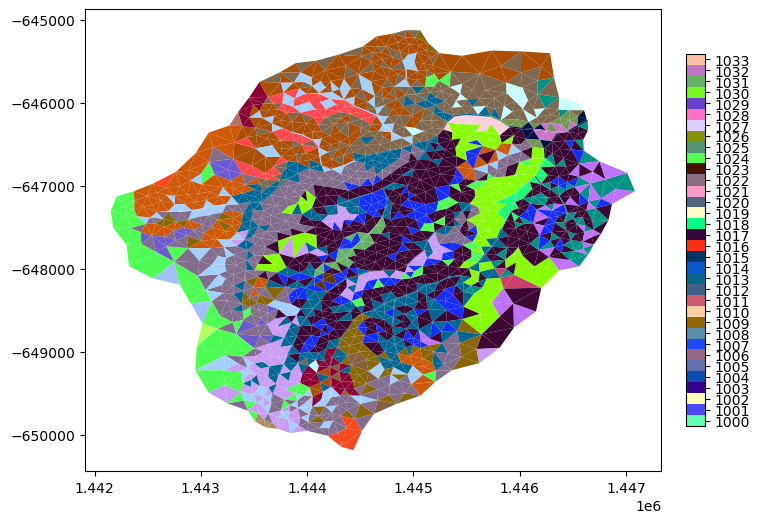

In [53]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from SoilGrids

In [54]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)['band_1']

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

In [55]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


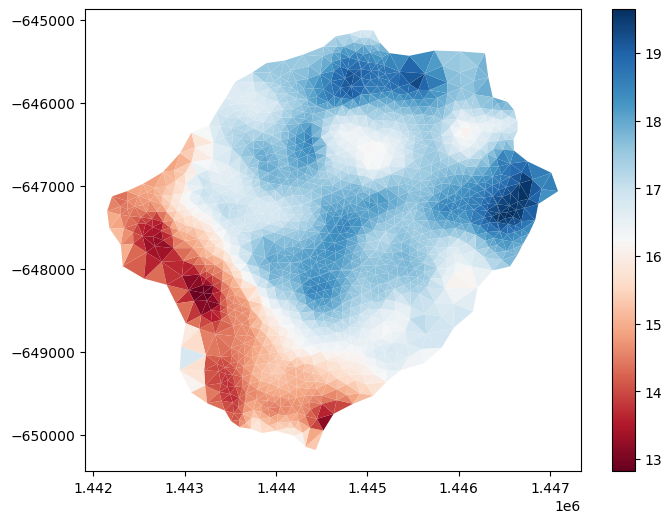

In [56]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [57]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, out_crs=crs)
glhymps = watershed_workflow.soil_properties.mangleGLHYMPSProperties(glhymps,
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

2025-08-26 22:33:50,604 - root - INFO: fixing column: geometry


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377015.684 -683020.036, 13769..."


In [58]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377015.684 -683020.036, 13769..."


In [59]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [60]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377015.684 -683020.036, 13769..."


In [61]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [62]:
geology_color_glhymps.min()

<xarray.DataArray 'index' ()> Size: 8B
array(0)

## Combine to form a complete subsurface dataset

In [63]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
output_filenames['subsurface_properties'] = toOutput(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(output_filenames['subsurface_properties'])
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377015.684 -683020.036, 13769...",NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444294.069 -650169.144, 14442...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443525.158 -646896.263, 14435...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447100.206 -649611.331, 14471...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447025.694 -649572.401, 14470...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444160.857 -649303.56, 144415...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443086.069 -650398.94, 144305...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445811.72 -649787.828, 144582...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1444203.528 -650183.69, 144421...",545814.0,2.03
1008,545815,NRCS-545815,NRCS,3.794887e-14,0.319402,0.000162,1.498482,0.177808,"MULTIPOLYGON (((1444285.044 -650166.508, 14442...",545815.0,2.03


# Extrude the 2D Mesh to make a 3D mesh

In [64]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 19.65074688662983 m


In [65]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05447108 0.07161305 0.11027281 0.17443206 0.26441087 0.36782677
 0.45697337 0.49999999]
2.0000000000000004


In [66]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [67]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[2.71113048 5.85796948 9.43304714 9.99786869 9.99998875 9.99999546]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [68]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


2025-08-26 22:33:51,120 - root - INFO: Cell summary:
2025-08-26 22:33:51,120 - root - INFO: ------------------------------------------------------------
2025-08-26 22:33:51,120 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-08-26 22:33:51,121 - root - INFO: ------------------------------------------------------------
2025-08-26 22:33:51,121 - root - INFO:  00 	| 00 	| 1008 	|   0.050000 	|   0.000000
2025-08-26 22:33:51,121 - root - INFO:  01 	| 01 	| 1008 	|   0.050000 	|   0.050000
2025-08-26 22:33:51,121 - root - INFO:  02 	| 02 	| 1008 	|   0.050000 	|   0.100000
2025-08-26 22:33:51,121 - root - INFO:  03 	| 03 	| 1008 	|   0.120000 	|   0.150000
2025-08-26 22:33:51,121 - root - INFO:  04 	| 04 	| 1008 	|   0.230000 	|   0.270000
2025-08-26 22:33:51,121 - root - INFO:  05 	| 05 	| 1008 	|   0.500000 	|   0.500000
2025-08-26 22:33:51,122 - root - INFO:  06 	| 06 	| 1008 	|   0.500000 	|   1.000000
2025-08-26 22:33:51,122 - root - INFO:  07 	| 07 	| 1008 	|   0.500000 	|   1.5

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377015.684 -683020.036, 13769...",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444294.069 -650169.144, 14442...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443525.158 -646896.263, 14435...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447100.206 -649611.331, 14471...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447025.694 -649572.401, 14470...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444160.857 -649303.56, 144415...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443086.069 -650398.94, 144305...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445811.72 -649787.828, 144582...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1444203.528 -650183.69, 144421...",545814.0,2.03


In [69]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [70]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
10000 : CELL : 2593 : "1"
10001 : CELL : 2593 : "1 surface"
10002 : FACE : 76 : "1 boundary"
10003 : FACE : 5 : "1 outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 184 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 46 : "stream order 2"
10008 : CELL : 122 : "stream order 1"
21 : CELL : 106 : "Developed, Open Space"
22 : CELL : 2 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 1340 : "Deciduous Forest"
42 : CELL : 47 : "Evergreen Forest"
43 : CELL : 1088 : "Mixed Forest"
81 : CELL : 8 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------
10000 : CELL : 38895 : "1"

Extruded 3D side sets
---------------------
1 : FACE : 2593 : "bottom"
2 : FACE : 2593 : "surface"
3 : FACE : 1140 : "external sides"
10001 : FACE : 2593 : "1 surface"
10002 : FACE : 1140 : "1 boundary"
10003 : FACE : 75 : "1 outlet"
10004 : FACE : 75 : "surface domain outlet"
10005 : FACE : 1

In [71]:
# save the mesh to disk
output_filenames['mesh'] = toOutput(f'{name}.exo')
try:
    os.remove(output_filenames['mesh'])
except FileNotFoundError:
    pass
m3.writeExodus(output_filenames['mesh'])


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta.exo


2025-08-26 22:33:51,452 - root - INFO: adding side set: 1
2025-08-26 22:33:51,457 - root - INFO: adding side set: 2
2025-08-26 22:33:51,461 - root - INFO: adding side set: 3
2025-08-26 22:33:51,463 - root - INFO: adding side set: 10001
2025-08-26 22:33:51,465 - root - INFO: adding side set: 10002
2025-08-26 22:33:51,467 - root - INFO: adding side set: 10003
2025-08-26 22:33:51,469 - root - INFO: adding side set: 10004
2025-08-26 22:33:51,470 - root - INFO: adding side set: 10005
2025-08-26 22:33:51,472 - root - INFO: adding side set: 10006
2025-08-26 22:33:51,474 - root - INFO: adding side set: 10007
2025-08-26 22:33:51,476 - root - INFO: adding side set: 10008
2025-08-26 22:33:51,477 - root - INFO: adding side set: 21
2025-08-26 22:33:51,480 - root - INFO: adding side set: 22
2025-08-26 22:33:51,482 - root - INFO: adding side set: 23
2025-08-26 22:33:51,483 - root - INFO: adding side set: 41
2025-08-26 22:33:51,486 - root - INFO: adding side set: 42
2025-08-26 22:33:51,487 - root - IN

Closing exodus file: /home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta.exo



Exodus Library Warning/Error: [ex_put_set] in file '/home/ecoon/code/watershed_workflow/repos/master/examples/Coweeta/output_data/Coweeta.exo'
